# Plotting

## Config

In [ ]:

import os
import json
from glob import glob
from collections import defaultdict


import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from statistics import mean
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
import pandas as pd

In [ ]:
# ------------------------------- setting start ------------------------------ #
# color
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
errorbar_color = "#3A3A3A"

# font
csfont = {'family':'Times New Roman', 'serif': 'Times' , 'size' : 23}
plt.rc('text', usetex=True)
plt.rc('font', **csfont)


# bar plot size
bar_width = 0.4
bar_btw_space = 0.04
bar_space = 0.2

# errorbar plot size
err_lw=1.5
err_capsize=4
err_capthick=1.5

# set fig size
figsize=(6.4, 4.8)
# -------------------------------- setting end ------------------------------- #

In [ ]:
# SCENE_NAME_LIST = ['drjohnson-dw50', 'bicycle-dw50', 'ship',  'mic','ficus', 'lego' ,'hotdog']
SCENE_NAME_LIST = ['hotdog', 'lego','ficus', 'mic'  ,'ship' ,'drjohnson-dw50', 'bicycle-dw50']


# complexity by 3dgs num :[?, ?, 325316, 307307]

def set_metric_ylim_fig(ax, metric_key, scene_name):
    """
    Set fixed y-axis limits for different metrics to ensure consistency across plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    
    # for outdoor scene (NeRF MIP360)
    if 'bicycle' in scene_name:
        if metric_key == 'PSNR':
            ax.set_ylim(20, 24)
        elif metric_key == 'SSIM':
            ax.set_ylim(0.35, 0.65)
        elif metric_key == 'LPIPS':
            pass
            # ax.set_ylim(0, 0.2)
    elif 'drjohnson' in scene_name:
        pass
    # for synthetic scenes (NeRF blender)
    else: 
        if metric_key == 'PSNR':
            ax.set_ylim(24.5, 35.0)
        elif metric_key == 'SSIM':
            ax.set_ylim(0.8, 1.0)
        elif metric_key == 'LPIPS':
            # ax.set_ylim(0, 0.2)
            pass
    
def set_metric_ylim_delta(ax, metric_key):
    """
    Set fixed y-axis limits for delta plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    if metric_key == 'PSNR':
        ax.set_ylim(-0.5, 5.5)  # Delta range for PSNR improvement
    elif metric_key == 'SSIM':
        ax.set_ylim(-0.01, 0.10)  # Delta range for SSIM improvement
    elif metric_key == 'LPIPS':
        # ax.set_ylim(-0.15, 0.01)  # Delta range for LPIPS improvement (lower is better)
        pass


## Figure Budget Policy

In [ ]:

def budget_policy_curves():
    """
    Plot metrics vs budget for different budgeting policies.
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    
    input_dir = Path('./data') / SCENE_NAME
    output_dir = Path('./plots') / 'budget_policy_curves' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define policies with their configurations
    policies = [
        {'name': 'distortion', 'label': 'Distortion', 'marker': 's', 'color': color_palette[2]},
        {'name': 'planarity2', 'label': 'Planarity', 'marker': '1', 'color': color_palette[4]},
        {'name': 'area', 'label': 'Area', 'marker': 'o', 'color': color_palette[1]},
        {'name': 'uniform', 'label': 'Uniform', 'marker': '^', 'color': color_palette[3]},
        # {'name': 'mixed_v1g3', 'label': 'Mixed vis1:geo3', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v2g2', 'label': 'Mixed vis1:geo1', 'marker': '2', 'color': color_palette[5]},
        # {'name': 'mixed_v3g1', 'label': 'Mixed vis3:geo1', 'marker': '3', 'color': color_palette[6]},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key}")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline
        mesh_mean = None
        mesh_stderr = None
        
        mesh_file = input_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
            
            if iter_key in data:
                metric_data = data[iter_key][metric_key]
                if isinstance(metric_data, dict):
                    values = [v for v in metric_data.values() if v != -1.0]
                else:
                    values = [metric_data]
                
                mesh_mean = np.mean(values)
                std_val = np.std(values)
                mesh_stderr = std_val / np.sqrt(len(values))
                print(f"Pure Mesh - {metric_key}: mean={mesh_mean:.4f}, std={std_val:.4f}, n={len(values)}")
        
        # 2. Process each policy
        for policy in policies:
            policy_name = policy['name']
            xs = []
            ys = []
            errs = []
            
            # Add pure mesh point at budget=0
            if mesh_mean is not None:
                xs.append(0)
                ys.append(mesh_mean)
                errs.append(mesh_stderr)
            
            print(f"\nProcessing {policy['label']}:")
            for budget in budgets:
                policy_file = input_dir / f"{policy_name}_{budget}_occlusion" / 'per_view_gs_mesh.json'
                
                if policy_file.exists():
                    with open(policy_file, 'r') as f:
                        data = json.load(f)
                    
                    if ITERATION in data:
                        metric_data = data[ITERATION][metric_key]
                        if isinstance(metric_data, dict):
                            values = [v for v in metric_data.values() if v != -1.0]
                        else:
                            values = [metric_data]
                        
                        mean_val = np.mean(values)
                        std_val = np.std(values)
                        stderr = std_val / np.sqrt(len(values))
                        num_splats = data[ITERATION].get('num_splats', budget)
                        
                        xs.append(num_splats)
                        ys.append(mean_val)
                        errs.append(stderr)
                        
                        print(f"  Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
            
            # Plot this policy
            if xs:
                print(f"  Plotting {len(xs)} points for {policy['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=policy['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=policy['color'], label=policy['label'], zorder=2)
            else:
                print(f"  No data to plot for {policy['label']}!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        set_metric_ylim_fig(ax, metric_key, SCENE_NAME)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_vs_budget_{SCENE_NAME}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()



# [TODO] [NOTE] fix y-axis range to enable comparison across plots
# the exact ranges for each set of figures might differ

# SCENE_NAME = 'lego'
# budget_policy_curves()


for name in SCENE_NAME_LIST:
    SCENE_NAME = name
    budget_policy_curves()




### figure budget bars

In [ ]:
def budget_policy_bars():
    """
    Bar plot comparing policy across scenes.
    fixed budget = 640k one set and 320k another set.
    For each metric (PSNR/SSIM/LPIPS):
    - x-axis: bar groups for each scene + overall average
    - Each group has bars for different renderers (DTGS, GaMeS)
    - y-axis: quality in PSNR/SSIM/LPIPS
    """
    

## Allocation Distribution Figure

In [ ]:
def plot_allocation_distribution(policy_file_path):
    """
    Plot allocation distribution figure.
    Sort according to number of allocated gaussians.
    Plot both CDF and PMF.
    
    Args:
        policy_file_path: Path to .npy file containing allocation array
                         e.g., 'data/lego/area_640000_occlusion/area_640000.npy'
    """
    # Load allocation data
    allocation = np.load(policy_file_path)
    
    # Sort by number of allocated gaussians (descending order)
    sorted_allocation = np.sort(allocation)[::-1]
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    print(f"\n{'='*60}")
    print(f"Plotting Allocation Distribution")
    print(f"File: {policy_file_path}")
    print(f"{'='*60}")
    print(f"Total mesh faces: {len(allocation)}")
    print(f"Total gaussians allocated: {np.sum(allocation)}")
    print(f"Mean gaussians per face: {np.mean(allocation):.2f}")
    print(f"Median gaussians per face: {np.median(allocation):.2f}")
    print(f"Max gaussians per face: {np.max(allocation)}")
    print(f"Min gaussians per face: {np.min(allocation)}")
    
    # --- Plot 1: PMF (Probability Mass Function) ---
    # Create histogram
    bins = np.arange(0, np.max(sorted_allocation) + 2) - 0.5
    counts, bin_edges = np.histogram(sorted_allocation, bins=bins)
    pmf = counts / len(sorted_allocation)
    
    # Bar plot for PMF
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax1.bar(bin_centers, pmf, width=0.8, 
            color=color_palette[0], alpha=0.7, edgecolor='black', linewidth=0.5)
    
    ax1.set_xlabel('Number of Gaussians per Face', fontsize=20)
    ax1.set_ylabel('Probability Mass', fontsize=20)
    ax1.set_title('PMF of Gaussian Allocation', fontsize=20)
    ax1.tick_params(labelsize=18)
    ax1.set_axisbelow(True)
    
    # --- Plot 2: CDF (Cumulative Distribution Function) ---
    # Calculate CDF
    sorted_unique = np.unique(sorted_allocation)
    cdf = np.array([np.sum(sorted_allocation <= val) / len(sorted_allocation) 
                    for val in sorted_unique])
    
    # Line plot for CDF
    ax2.plot(sorted_unique, cdf, 
             marker='o', markersize=4, linewidth=2, 
             color=color_palette[1], label='CDF')
    
    # Add reference lines
    ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50th percentile')
    ax2.axhline(y=0.9, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='90th percentile')
    
    ax2.set_xlabel('Number of Gaussians per Face', fontsize=20)
    ax2.set_ylabel('Cumulative Probability', fontsize=20)
    ax2.set_title('CDF of Gaussian Allocation', fontsize=20)
    ax2.set_ylim(-0.05, 1.05)
    ax2.tick_params(labelsize=18)
    ax2.legend(loc='lower right', framealpha=0.9, fontsize=16)
    ax2.set_axisbelow(True)
    
    fig.set_constrained_layout(True)
    
    # Save figure
    policy_path = Path(policy_file_path)
    scene_name = policy_path.parent.parent.name
    policy_name = policy_path.parent.name
    
    output_dir = Path('./plots') / 'allocation_distribution' / scene_name
    output_dir.mkdir(parents=True, exist_ok=True)
    
    base_name = f'allocation_dist_{policy_name}'
    plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
    print(f"\nSaved: {base_name}.png and .eps\n")
    
    plt.show()
    plt.close()


# Example usage:
# plot_allocation_distribution('data/lego/area_640000_occlusion/area_640000.npy')

# Or run for all scenes and policies:
def plot_all_allocation_distributions():
    """Plot allocation distributions for all scenes and policies."""
    # budgets = [40000, 80000, 160000, 320000, 640000]
    budgets = [640000]
    
    policies = ['area', 'distortion', 'uniform', 'planarity2']
    
    for scene in ['lego']:
        for policy in policies:
            for budget in budgets:
                npy_path = Path('./data') / scene / f'{policy}_{budget}_occlusion' / f'{policy}_{budget}.npy'
                if npy_path.exists():
                    print(f"\nProcessing {scene} - {policy} - {budget}")
                    plot_allocation_distribution(npy_path)
                else:
                    print(f"[WARN] File not found: {npy_path}")

# Uncomment to run for all:

# plot_all_allocation_distributions()

In [ ]:
def plot_weights_cdf_pdf(scene_name='lego', policy_name='distortion', normalize=False):
    """
    Plot weight distribution figure for a given scene and policy.
    Shows both CDF and PDF (histogram).
    
    Args:
        scene_name: Scene name (e.g., 'lego', 'ficus', 'bicycle-dw50')
        policy_name: Policy name (e.g., 'area', 'distortion', 'uniform', 'planarity2')
        normalize: If True, normalize weights to sum to 1
    """
    
    # Construct path to weights file
    weights_dir = Path('./data/weights') / scene_name / 'policy' / 'mesh_milo'
    
    # Find the weights file for this policy
    weights_file = None
    for tri_dir in weights_dir.glob('tri_*'):
        candidate = tri_dir / policy_name / 'weights.npy'
        if candidate.exists():
            weights_file = candidate
            break
    
    if weights_file is None:
        print(f"[ERROR] No weights file found for {scene_name} - {policy_name}")
        return
    
    # Load weights data
    weights = np.load(weights_file)
    
    # Normalize if requested
    if normalize:
        weights = weights / np.sum(weights)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    print(f"\n{'='*60}")
    print(f"Plotting Weight Distribution")
    print(f"Scene: {scene_name}, Policy: {policy_name}")
    print(f"File: {weights_file}")
    print(f"{'='*60}")
    print(f"Total mesh faces: {len(weights)}")
    print(f"Sum of weights: {np.sum(weights):.4f}")
    print(f"Mean weight: {np.mean(weights):.6f}")
    print(f"Median weight: {np.median(weights):.6f}")
    print(f"Std weight: {np.std(weights):.6f}")
    print(f"Max weight: {np.max(weights):.6f}")
    print(f"Min weight: {np.min(weights):.6f}")
    
    # Calculate percentiles for better x-axis limits
    p99 = np.percentile(weights, 99)
    p95 = np.percentile(weights, 95)
    p90 = np.percentile(weights, 90)
    
    print(f"90th percentile: {p90:.6f}")
    print(f"95th percentile: {p95:.6f}")
    print(f"99th percentile: {p99:.6f}")
    
    # --- Plot 1: PDF (Probability Density Function) - Histogram ---
    # Use percentile-based x-limit to focus on the main distribution
    # Show up to 99th percentile to exclude extreme outliers
    xlim_max = p99 * 1.1  # Add 10% padding
    
    # Filter weights for histogram to focus on main distribution
    weights_filtered = weights[weights <= xlim_max]
    
    n_bins = 50
    counts, bin_edges, patches = ax1.hist(weights_filtered, bins=n_bins, 
                                           density=True,
                                           color=color_palette[0], 
                                           alpha=0.7, 
                                           edgecolor='black', 
                                           linewidth=0.5)
    
    ax1.set_xlabel('Weight Value', fontsize=20)
    ax1.set_ylabel('Probability Density', fontsize=20)
    ax1.set_title('PDF of Policy Weights', fontsize=20)
    ax1.set_xlim(0, xlim_max)
    ax1.tick_params(labelsize=18)
    ax1.set_axisbelow(True)
    
    # Add mean and median lines
    mean_weight = np.mean(weights)
    median_weight = np.median(weights)
    
    if mean_weight <= xlim_max:
        ax1.axvline(x=mean_weight, color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {mean_weight:.4f}')
    if median_weight <= xlim_max:
        ax1.axvline(x=median_weight, color='orange', linestyle=':', 
                    linewidth=2, label=f'Median: {median_weight:.4f}')
    
    ax1.legend(loc='best', framealpha=0.9, fontsize=16)
    
    # --- Plot 2: CDF (Cumulative Distribution Function) ---
    sorted_weights = np.sort(weights)
    cdf = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
    
    # Line plot for CDF
    ax2.plot(sorted_weights, cdf, 
             linewidth=2, 
             color=color_palette[1], 
             label='CDF')
    
    # Add reference lines at percentiles
    ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, 
                label='50th percentile')
    ax2.axhline(y=0.9, color='gray', linestyle=':', linewidth=1, alpha=0.5, 
                label='90th percentile')
    ax2.axhline(y=0.95, color='gray', linestyle='-.', linewidth=1, alpha=0.5, 
                label='95th percentile')
    
    # Add vertical line at median
    ax2.axvline(x=median_weight, color='orange', linestyle=':', linewidth=2, 
                label=f'Median: {median_weight:.4f}')
    
    ax2.set_xlabel('Weight Value', fontsize=20)
    ax2.set_ylabel('Cumulative Probability', fontsize=20)
    ax2.set_title(f'CDF of Policy Weights {policy_name}', fontsize=20)
    ax2.set_xlim(0, xlim_max)
    ax2.set_ylim(-0.05, 1.05)
    ax2.tick_params(labelsize=18)
    ax2.legend(loc='lower right', framealpha=0.9, fontsize=14)
    ax2.set_axisbelow(True)
    
    fig.set_constrained_layout(True)
    
    # Save figure
    output_dir = Path('./plots') / 'weight_distribution' / scene_name
    output_dir.mkdir(parents=True, exist_ok=True)
    
    base_name = f'weights_dist_{policy_name}'
    if normalize:
        base_name += '_normalized'
    
    plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
    print(f"\nSaved: {base_name}.png and .eps\n")
    
    plt.show()
    plt.close()

def plot_all_weight_distributions():
    """Plot weight distributions for all available scene-policy combinations."""
    
    weights_base = Path('./data/weights')
    
    # Scene to policy mapping (based on what's available)
    scene_policies = {
        'lego': ['area', 'distortion', 'planarity2'],
        'ficus': ['area', 'distortion', 'planarity2'],
        'hotdog': ['area', 'distortion', 'planarity2'],
        'mic': ['area', 'distortion', 'planarity2'],
        'ship': ['area', 'distortion', 'planarity2'],
        'bicycle-dw50': ['area', 'distortion', 'planarity2'],
        'drjohnson-dw50': ['area', 'distortion', 'planarity2'],
    }
    
    for scene, policies in scene_policies.items():
        scene_dir = weights_base / scene / 'policy' / 'mesh_milo'
        
        if not scene_dir.exists():
            print(f"[WARN] Scene directory not found: {scene_dir}")
            continue
        
        print(f"\n{'#'*60}")
        print(f"Processing scene: {scene}")
        print(f"{'#'*60}")
        
        for policy in policies:
            # Check if this policy exists for this scene
            found = False
            for tri_dir in scene_dir.glob('tri_*'):
                if (tri_dir / policy / 'weights.npy').exists():
                    found = True
                    break
            
            if found:
                plot_weights_cdf_pdf(scene, policy)
            else:
                print(f"[SKIP] No weights found for {scene} - {policy}")


# Example usage:
# Plot single scene-policy combination
# plot_weights_cdf_pdf('lego', 'distortion')

# Or plot all available combinations
# plot_all_weight_distributions()


# SCENE='lego'
# budget_policy_curves()



## Figure Delta (DTGS - Pure Mesh)

In [ ]:

def policy_budget_delta_curves():
    """
    Plot average delta (improvement over pure mesh) across all scenes.
    
    Average across all nerf-synthetic scenes 
    (the 5 scenes we used are ficus, hotdog, lego, mic, ship)
    x-axis: budget number (0, 40k, 80k, 160k, 320k, 640k)
    y-axis: delta of quality in PSNR/SSIM/LPIPS (compared to pure mesh baseline)
    hue: different budgeting policies
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    # Define policies with their configurations
    policies = [
        {'name': 'area', 'label': 'Area-based', 'marker': 'o', 'color': color_palette[1]},
        {'name': 'distortion', 'label': 'Distortion-based', 'marker': 's', 'color': color_palette[2]},
        {'name': 'uniform', 'label': 'Uniform', 'marker': '^', 'color': color_palette[3]},
        {'name': 'planarity2', 'label': 'Planarity', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v1g3', 'label': 'Mixed vis1:geo3', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v2g2', 'label': 'Mixed vis1:geo1', 'marker': '2', 'color': color_palette[5]},
        # {'name': 'mixed_v3g1', 'label': 'Mixed vis3:geo1', 'marker': '3', 'color': color_palette[6]},
    ]
    
    input_base = Path('./data')
    output_dir = Path('./plots') / 'budget_policy_delta_curves'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    metrics = {
        'PSNR': {'ylabel': r'$\Delta$ in PSNR (dB)', 'title': 'PSNR Improvement'},
        'SSIM': {'ylabel': r'$\Delta$ in SSIM', 'title': 'SSIM Improvement'},
        'LPIPS': {'ylabel': r'$\Delta$ LPIPS', 'title': 'LPIPS Improvement'}
    }
    
    # For each metric, create one plot
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Computing Average Delta for {metric_key}")
        print(f"{'='*60}")
        
        # Store data for each policy
        policy_data = {p['name']: {'xs': [], 'ys': [], 'errs': []} for p in policies}
        
        # For each budget level
        for budget in budgets:
            print(f"\nProcessing budget: {budget}")
            
            # Collect deltas for each policy across all scenes
            policy_deltas = {p['name']: [] for p in policies}
            
            for scene in SCENE_NAME_LIST:
                scene_dir = input_base / scene
                
                # Get pure mesh baseline for this scene
                mesh_file = scene_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
                
                if not mesh_file.exists():
                    print(f"  [WARN] Missing mesh file for {scene}")
                    continue
                
                with open(mesh_file, 'r') as f:
                    mesh_data = json.load(f)
                
                iter_key = MESH_ITERATION if MESH_ITERATION in mesh_data else ITERATION
                
                if iter_key not in mesh_data:
                    print(f"  [WARN] No iteration key found in mesh file for {scene}")
                    continue
                
                # Get baseline metric value
                mesh_metric = mesh_data[iter_key][metric_key]
                if isinstance(mesh_metric, dict):
                    mesh_values = [v for v in mesh_metric.values() if v != -1.0]
                    baseline = np.mean(mesh_values)
                else:
                    baseline = mesh_metric
                
                # For each policy, compute delta
                for policy in policies:
                    policy_name = policy['name']
                    policy_file = scene_dir / f'{policy_name}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                    
                    if not policy_file.exists():
                        print(f"  [WARN] Missing {policy_name} file for {scene} at budget {budget}")
                        continue
                    
                    with open(policy_file, 'r') as f:
                        policy_file_data = json.load(f)
                    
                    if ITERATION not in policy_file_data:
                        print(f"  [WARN] No {ITERATION} in {policy_name} file for {scene}")
                        continue
                    
                    # Get policy metric value
                    policy_metric = policy_file_data[ITERATION][metric_key]
                    if isinstance(policy_metric, dict):
                        policy_values = [v for v in policy_metric.values() if v != -1.0]
                        policy_val = np.mean(policy_values)
                    else:
                        policy_val = policy_metric
                    
                    # Compute delta (improvement over baseline)
                    # For LPIPS, lower is better
                    delta = policy_val - baseline  # Positive = improvement
                    
                    policy_deltas[policy_name].append(delta)
                    print(f"  {scene} {policy_name}: baseline={baseline:.4f}, policy={policy_val:.4f}, delta={delta:.4f}")
            
            # Compute average delta and standard error across scenes
            for policy in policies:
                policy_name = policy['name']
                if len(policy_deltas[policy_name]) > 0:
                    deltas = np.array(policy_deltas[policy_name])
                    mean_delta = np.mean(deltas)
                    std_delta = np.std(deltas)
                    stderr_delta = std_delta / np.sqrt(len(deltas))
                    
                    policy_data[policy_name]['xs'].append(budget)
                    policy_data[policy_name]['ys'].append(mean_delta)
                    policy_data[policy_name]['errs'].append(stderr_delta)
                    
                    print(f"  {policy_name} average: mean={mean_delta:.4f}, std={std_delta:.4f}, n={len(deltas)}")
        
        # Add budget=0 point (delta=0 by definition)
        for policy in policies:
            policy_name = policy['name']
            if len(policy_data[policy_name]['xs']) > 0:
                policy_data[policy_name]['xs'].insert(0, 0)
                policy_data[policy_name]['ys'].insert(0, 0.0)
                policy_data[policy_name]['errs'].insert(0, 0.0)
        
        # Plot each policy
        for policy in policies:
            policy_name = policy['name']
            if len(policy_data[policy_name]['xs']) > 0:
                ax.errorbar(
                    policy_data[policy_name]['xs'], 
                    policy_data[policy_name]['ys'], 
                    yerr=policy_data[policy_name]['errs'],
                    marker=policy['marker'], 
                    markersize=8, 
                    linewidth=2.5,
                    capsize=err_capsize, 
                    capthick=err_capthick,
                    color=policy['color'], 
                    label=policy['label'], 
                    zorder=2
                )
                print(f"\n[INFO] Plotted {len(policy_data[policy_name]['xs'])} points for {policy['label']}")
        
        # Add horizontal line at y=0 (no improvement)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians)', fontsize=20)
        ax.set_ylabel(metric_info['ylabel'], fontsize=20)
        
        # Set fixed y-axis range
        set_metric_ylim_delta(ax, metric_key)
        
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_delta_vs_budget_average'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n[INFO] Saved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()




policy_budget_delta_curves()


## Fig Renderer Comparison

compare DTGS, GaMeS

In [ ]:
def plot_renderer_comp():
    """
    Compare different renderer/training pipelines (DTGS, GaMeS)
    under same budget/scene using uniform policy.
    
    the renderer used consistently in training and evaluation
    
    
    x-axis: bit budget in #Gaussians (40k, 80k, 160k, 320k, 640k)
    y-axis: quality in PSNR/SSIM/LPIPS
    hue: [DTGS (ours), GaMeS]
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    POLICY = 'uniform'
    
    input_dir = Path('./data')
    games_dir = Path('./data/games_results')
    output_dir = Path('./plots') / 'renderer_comp' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define renderers/pipelines with their configurations
    renderers = [
        {'name': 'dtgs', 'label': 'DTGS (Ours)', 'marker': 'o', 'color': color_palette[0], 
         'is_games': False},
        {'name': 'games', 'label': 'GaMeS', 'marker': '^', 'color': color_palette[2], 
         'is_games': True},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key} - Renderer Comparison for {SCENE_NAME}")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline (shared across all renderers)
        mesh_mean = None
        mesh_stderr = None
        
        mesh_file = input_dir / SCENE_NAME / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
            
            if iter_key in data:
                metric_data = data[iter_key][metric_key]
                if isinstance(metric_data, dict):
                    values = [v for v in metric_data.values() if v != -1.0]
                else:
                    values = [metric_data]
                
                mesh_mean = np.mean(values)
                std_val = np.std(values)
                mesh_stderr = std_val / np.sqrt(len(values))
                print(f"Pure Mesh - {metric_key}: mean={mesh_mean:.4f}, std={std_val:.4f}, n={len(values)}")
        
        # Store renderer data for comparison
        renderer_data = {r['name']: {'xs': [], 'ys': [], 'errs': []} for r in renderers}
        
        # 2. Process each renderer
        for renderer in renderers:
            renderer_name = renderer['name']
            is_games = renderer['is_games']
            
            xs = []
            ys = []
            errs = []
            
            # [NOTE] Our x=0 is mesh background, whereas GaMeS is blank
            if mesh_mean is not None:
                xs.append(0)
                if is_games: #GaMeS results do not include pure mesh point
                    ys.append( 1 if metric_key=='LPIPS' else 0 )
                    errs.append(0)
                else: #our DTGS results include pure mesh point
                    ys.append(mesh_mean)
                    errs.append(mesh_stderr)
            
            print(f"\nProcessing {renderer['label']}:")
            
            for budget in budgets:
                # Determine the correct file path
                if is_games:
                    # GaMeS results are in games_results folder
                    scene_dir = games_dir / SCENE_NAME
                    policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                else:
                    # DTGS results are in main data folder
                    scene_dir = input_dir / SCENE_NAME
                    policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                
                if policy_file.exists():
                    with open(policy_file, 'r') as f:
                        data = json.load(f)
                    
                    if ITERATION in data:
                        metric_data = data[ITERATION][metric_key]
                        if isinstance(metric_data, dict):
                            values = [v for v in metric_data.values() if v != -1.0]
                        else:
                            values = [metric_data]
                        
                        mean_val = np.mean(values)
                        std_val = np.std(values)
                        stderr = std_val / np.sqrt(len(values))
                        num_splats = data[ITERATION].get('num_splats', budget)
                        
                        xs.append(num_splats)
                        ys.append(mean_val)
                        errs.append(stderr)
                        
                        print(f"  Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"  Budget {budget}: File not found - {policy_file}")
            
            # Store data for comparison
            renderer_data[renderer_name]['xs'] = xs
            renderer_data[renderer_name]['ys'] = ys
            renderer_data[renderer_name]['errs'] = errs
            
            # Plot this renderer
            if xs:
                print(f"  Plotting {len(xs)} points for {renderer['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=renderer['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=renderer['color'], label=renderer['label'], zorder=2)
            else:
                print(f"  No data to plot for {renderer['label']}!")
        
        # Print differences between renderers at each budget
        print(f"\n{'='*60}")
        print(f"Renderer Differences for {metric_key}")
        print(f"{'='*60}")
        
        # Find common budgets (excluding budget=0)
        dtgs_budgets = set(renderer_data['dtgs']['xs'][1:])  # Skip x=0
        games_budgets = set(renderer_data['games']['xs'][1:])
        
        common_budgets = sorted(dtgs_budgets & games_budgets)
        
        for budget in common_budgets:
            # Find indices for this budget
            dtgs_idx = renderer_data['dtgs']['xs'].index(budget)
            games_idx = renderer_data['games']['xs'].index(budget)
            
            dtgs_val = renderer_data['dtgs']['ys'][dtgs_idx]
            games_val = renderer_data['games']['ys'][games_idx]
            
            # Calculate differences
            dtgs_games_diff = dtgs_val - games_val  # Positive means DTGS is better
            
            print(f"\nBudget {int(budget/1000)}K:")
            print(f"  DTGS:  {dtgs_val:.4f}")
            print(f"  GaMeS: {games_val:.4f}")
            print(f"  DTGS - GaMeS: {dtgs_games_diff:+.4f} ({abs(dtgs_games_diff/games_val*100):.2f}%)")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        # set_metric_ylim_fig(ax, metric_key, SCENE_NAME)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_renderer_comp_{SCENE_NAME}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run for all scenes
for name in SCENE_NAME_LIST:
    SCENE_NAME = name
    plot_renderer_comp()

# SCENE_NAME = 'lego'
# plot_renderer_comp()

In [ ]:
def plot_renderer_comp_average():
    """
    Compare different renderer/training pipelines (DTGS, GaMeS)
    the renderer used consistently in training and evaluation
    averaged across all scenes using uniform policy.
    
    x-axis: bit budget in #Gaussians (40k, 80k, 160k, 320k, 640k)
    y-axis: average quality in PSNR/SSIM/LPIPS across all scenes
    hue: [DTGS (ours), GaMeS]
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    POLICY = 'uniform'
    
    
    input_dir = Path('./data')
    games_dir = Path('./data/games_results')
    output_dir = Path('./plots') / 'renderer_comp_average'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define renderers/pipelines with their configurations
    renderers = [
        {'name': 'dtgs', 'label': 'DTGS (Ours)', 'marker': 'o', 'color': color_palette[0], 
         'is_games': False},
        {'name': 'games', 'label': 'GaMeS', 'marker': '^', 'color': color_palette[2], 
         'is_games': True},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Average {metric_key} - Renderer Comparison")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline averaged across all scenes
        mesh_values_all_scenes = []
        
        for scene in SCENE_NAME_LIST:
            mesh_file = input_dir / scene / 'area_1_occlusion' / 'per_view_gs_mesh.json'
            if mesh_file.exists():
                with open(mesh_file, 'r') as f:
                    data = json.load(f)
                
                iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
                
                if iter_key in data:
                    metric_data = data[iter_key][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                        scene_mean = np.mean(values)
                    else:
                        scene_mean = metric_data
                    
                    mesh_values_all_scenes.append(scene_mean)
                    print(f"  {scene} - Pure Mesh: {scene_mean:.4f}")
        
        mesh_mean = None
        mesh_stderr = None
        if mesh_values_all_scenes:
            mesh_mean = np.mean(mesh_values_all_scenes)
            mesh_std = np.std(mesh_values_all_scenes)
            mesh_stderr = mesh_std / np.sqrt(len(mesh_values_all_scenes))
            print(f"Pure Mesh Average - {metric_key}: mean={mesh_mean:.4f}, std={mesh_std:.4f}, n={len(mesh_values_all_scenes)}")
        
        # 2. Process each renderer
        for renderer in renderers:
            renderer_name = renderer['name']
            is_games = renderer['is_games']
            
            xs = []
            ys = []
            errs = []
            
           # [NOTE] Our x=0 is mesh background, whereas GaMeS is blank
            if mesh_mean is not None:
                xs.append(0)
                if is_games: #GaMeS results do not include pure mesh point
                    ys.append( 1 if metric_key=='LPIPS' else 0 )
                    errs.append(0)
                else: #our DTGS results include pure mesh point
                    ys.append(mesh_mean)
                    errs.append(mesh_stderr)
            
            print(f"\nProcessing {renderer['label']}:")
            
            for budget in budgets:
                # Collect values across all scenes for this budget
                budget_values_all_scenes = []
                
                for scene in SCENE_NAME_LIST:
                    # Determine the correct file path
                    if is_games:
                        scene_dir = games_dir / scene
                    else:
                        scene_dir = input_dir / scene
                    
                    policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                    
                    if policy_file.exists():
                        with open(policy_file, 'r') as f:
                            data = json.load(f)
                        
                        if ITERATION in data:
                            metric_data = data[ITERATION][metric_key]
                            if isinstance(metric_data, dict):
                                values = [v for v in metric_data.values() if v != -1.0]
                                scene_mean = np.mean(values)
                            else:
                                scene_mean = metric_data
                            
                            budget_values_all_scenes.append(scene_mean)
                            print(f"  {scene} @ {budget}: {scene_mean:.4f}")
                    else:
                        print(f"  {scene} @ {budget}: File not found")
                
                # Compute average across scenes
                if budget_values_all_scenes:
                    mean_val = np.mean(budget_values_all_scenes)
                    std_val = np.std(budget_values_all_scenes)
                    stderr = std_val / np.sqrt(len(budget_values_all_scenes))
                    
                    xs.append(budget)
                    ys.append(mean_val)
                    errs.append(stderr)
                    
                    print(f"  Budget {budget} Average: mean={mean_val:.4f}, std={std_val:.4f}, n={len(budget_values_all_scenes)}")
            
            # Plot this renderer
            if xs:
                print(f"  Plotting {len(xs)} points for {renderer['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=renderer['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=renderer['color'], label=renderer['label'], zorder=2)
            else:
                print(f"  No data to plot for {renderer['label']}!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        if metric_key == 'SSIM':
            ax.set_ylim(top=1.01)
        
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_renderer_comp_average'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run averaged comparison
plot_renderer_comp_average()


Plotting Bar Chart for PSNR (averaged across all budgets)
  hotdog @ 40K - DTGS: 30.2968
  hotdog @ 80K - DTGS: 31.0009
  hotdog @ 160K - DTGS: 31.6947
  hotdog @ 320K - DTGS: 32.8689
  hotdog @ 640K - DTGS: 34.6858
  hotdog - DTGS (avg across budgets): 32.1094
  lego @ 40K - DTGS: 26.1978
  lego @ 80K - DTGS: 26.5980
  lego @ 160K - DTGS: 27.9698
  lego @ 320K - DTGS: 28.4245
  lego @ 640K - DTGS: 29.0138
  lego - DTGS (avg across budgets): 27.6408
  ficus @ 40K - DTGS: 25.7287
  ficus @ 80K - DTGS: 26.1382
  ficus @ 160K - DTGS: 26.2570
  ficus @ 320K - DTGS: 26.3771
  ficus @ 640K - DTGS: 26.7055
  ficus - DTGS (avg across budgets): 26.2413
  mic @ 40K - DTGS: 26.7358
  mic @ 80K - DTGS: 27.0708
  mic @ 160K - DTGS: 27.7272
  mic @ 320K - DTGS: 29.1427
  mic @ 640K - DTGS: 29.5033
  mic - DTGS (avg across budgets): 28.0360
  ship @ 40K - DTGS: 25.4912
  ship @ 80K - DTGS: 26.0101
  ship @ 160K - DTGS: 26.2219
  ship @ 320K - DTGS: 26.8025
  ship @ 640K - DTGS: 27.9691
  ship - DTGS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: PSNR_renderer_comp_bar_avg_all_budgets.png and .eps



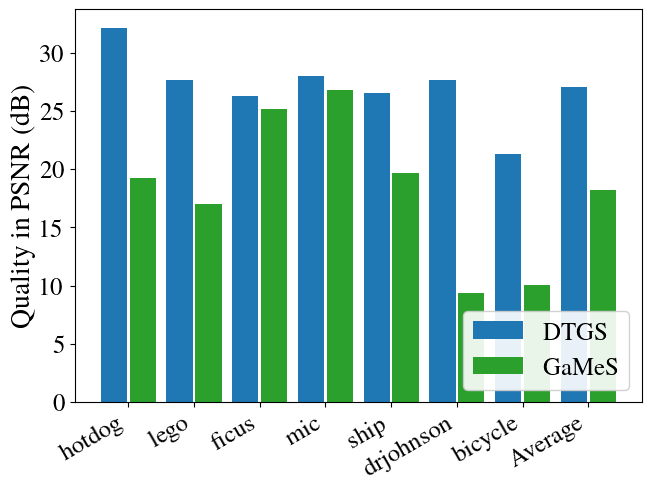


Plotting Bar Chart for SSIM (averaged across all budgets)
  hotdog @ 40K - DTGS: 0.9612
  hotdog @ 80K - DTGS: 0.9653
  hotdog @ 160K - DTGS: 0.9675
  hotdog @ 320K - DTGS: 0.9730
  hotdog @ 640K - DTGS: 0.9795
  hotdog - DTGS (avg across budgets): 0.9693
  lego @ 40K - DTGS: 0.9153
  lego @ 80K - DTGS: 0.9211
  lego @ 160K - DTGS: 0.9332
  lego @ 320K - DTGS: 0.9383
  lego @ 640K - DTGS: 0.9471
  lego - DTGS (avg across budgets): 0.9310
  ficus @ 40K - DTGS: 0.9201
  ficus @ 80K - DTGS: 0.9255
  ficus @ 160K - DTGS: 0.9280
  ficus @ 320K - DTGS: 0.9321
  ficus @ 640K - DTGS: 0.9393
  ficus - DTGS (avg across budgets): 0.9290
  mic @ 40K - DTGS: 0.9253
  mic @ 80K - DTGS: 0.9298
  mic @ 160K - DTGS: 0.9423
  mic @ 320K - DTGS: 0.9546
  mic @ 640K - DTGS: 0.9628
  mic - DTGS (avg across budgets): 0.9429
  ship @ 40K - DTGS: 0.8275
  ship @ 80K - DTGS: 0.8361
  ship @ 160K - DTGS: 0.8393
  ship @ 320K - DTGS: 0.8499
  ship @ 640K - DTGS: 0.8670
  ship - DTGS (avg across budgets): 0.8439

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: SSIM_renderer_comp_bar_avg_all_budgets.png and .eps



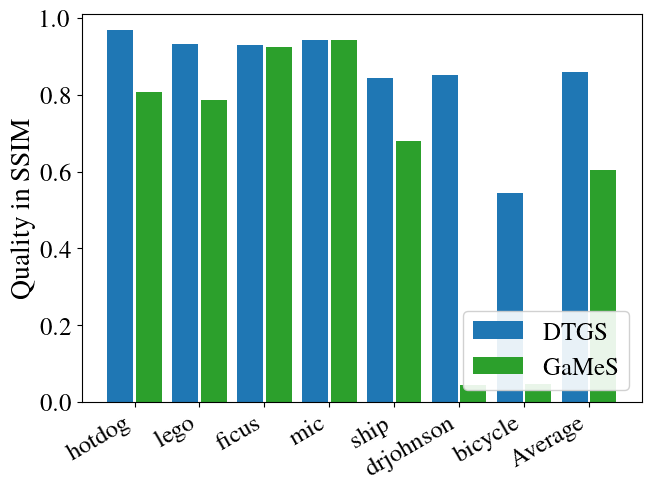


Plotting Bar Chart for LPIPS (averaged across all budgets)
  hotdog @ 40K - DTGS: 0.0698
  hotdog @ 80K - DTGS: 0.0661
  hotdog @ 160K - DTGS: 0.0628
  hotdog @ 320K - DTGS: 0.0549
  hotdog @ 640K - DTGS: 0.0404
  hotdog - DTGS (avg across budgets): 0.0588
  lego @ 40K - DTGS: 0.1020
  lego @ 80K - DTGS: 0.1006
  lego @ 160K - DTGS: 0.0980
  lego @ 320K - DTGS: 0.0894
  lego @ 640K - DTGS: 0.0724
  lego - DTGS (avg across budgets): 0.0925
  ficus @ 40K - DTGS: 0.0900
  ficus @ 80K - DTGS: 0.0885
  ficus @ 160K - DTGS: 0.0847
  ficus @ 320K - DTGS: 0.0773
  ficus @ 640K - DTGS: 0.0649
  ficus - DTGS (avg across budgets): 0.0811
  mic @ 40K - DTGS: 0.0875
  mic @ 80K - DTGS: 0.0841
  mic @ 160K - DTGS: 0.0703
  mic @ 320K - DTGS: 0.0549
  mic @ 640K - DTGS: 0.0432
  mic - DTGS (avg across budgets): 0.0680
  ship @ 40K - DTGS: 0.2034
  ship @ 80K - DTGS: 0.1943
  ship @ 160K - DTGS: 0.1835
  ship @ 320K - DTGS: 0.1707
  ship @ 640K - DTGS: 0.1418
  ship - DTGS (avg across budgets): 0.178

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: LPIPS_renderer_comp_bar_avg_all_budgets.png and .eps



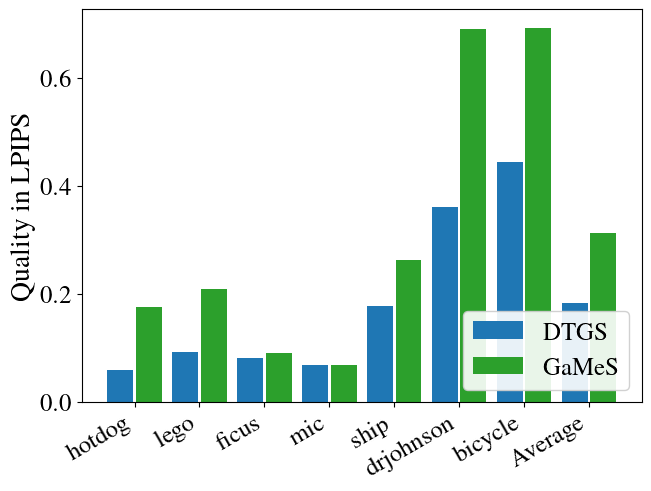

In [105]:
def plot_renderer_comp_bar():
    """
    Bar plot comparing renderers across scenes.
    
    For each metric (PSNR/SSIM/LPIPS):
    - x-axis: bar groups for each scene + overall average
    - Each group has bars for different renderers (DTGS, GaMeS)
    - y-axis: quality in PSNR/SSIM/LPIPS
    - Values are averaged across all budgets (40k, 80k, 160k, 320k, 640k)
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    POLICY = 'uniform'
    BUDGETS = [40000, 80000, 160000, 320000, 640000]  # Average across all budgets
    
    input_dir = Path('./data')
    games_dir = Path('./data/games_results')
    output_dir = Path('./plots') / 'renderer_comp_bar'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define renderers
    renderers = [
        {'name': 'dtgs', 'label': 'DTGS', 'color': color_palette[0], 'is_games': False},
        {'name': 'games', 'label': 'GaMeS', 'color': color_palette[2], 'is_games': True},
    ]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    # For each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Bar Chart for {metric_key} (averaged across all budgets)")
        print(f"{'='*60}")
        
        # x-axis labels: scene names + "Average"
        x_labels = [scene.replace('-dw50', '') for scene in SCENE_NAME_LIST] + ['Average']
        n_groups = len(x_labels)
        n_renderers = len(renderers)
        
        # Bar positions
        x_pos = np.arange(n_groups) * (n_renderers * bar_width + bar_space)
        
        # Collect data for each renderer
        for renderer_idx, renderer in enumerate(renderers):
            renderer_name = renderer['name']
            is_games = renderer['is_games']
            
            group_values = []  # Values for each scene + average
            
            # Collect values for each scene
            scene_values = []
            
            for scene in SCENE_NAME_LIST:
                # Determine file path
                if is_games:
                    scene_dir = games_dir / scene
                else:
                    scene_dir = input_dir / scene
                
                # Collect values across all budgets for this scene
                budget_values = []
                
                for budget in BUDGETS:
                    policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                    
                    if policy_file.exists():
                        with open(policy_file, 'r') as f:
                            data = json.load(f)
                        
                        if ITERATION in data:
                            metric_data = data[ITERATION][metric_key]
                            if isinstance(metric_data, dict):
                                values = [v for v in metric_data.values() if v != -1.0]
                                budget_mean = np.mean(values)
                            else:
                                budget_mean = metric_data
                            
                            budget_values.append(budget_mean)
                            print(f"  {scene} @ {budget//1000}K - {renderer['label']}: {budget_mean:.4f}")
                
                # Average across budgets for this scene
                if budget_values:
                    scene_avg = np.mean(budget_values)
                    group_values.append(scene_avg)
                    scene_values.append(scene_avg)
                    print(f"  {scene} - {renderer['label']} (avg across budgets): {scene_avg:.4f}")
                else:
                    group_values.append(0)
                    print(f"  {scene} - {renderer['label']}: No data found")
            
            # Add overall average
            if scene_values:
                overall_mean = np.mean(scene_values)
                group_values.append(overall_mean)
                print(f"  Overall - {renderer['label']}: mean={overall_mean:.4f}")
            else:
                group_values.append(0)
            
            # Plot bars
            offset = renderer_idx * (bar_width + bar_btw_space)
            ax.bar(x_pos + offset, group_values, bar_width,
                   label=renderer['label'], color=renderer['color'])
        
        # Formatting
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        ax.set_xticks(x_pos + (n_renderers - 1) * (bar_width + bar_btw_space) / 2)
        ax.set_xticklabels(x_labels, fontsize=16, rotation=30, ha='right')
        ax.legend(loc='lower right', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_axisbelow(True)
        
        if metric_key == 'SSIM':
            ax.set_ylim(top=1.01)
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_renderer_comp_bar_avg_all_budgets'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run the bar plot
plot_renderer_comp_bar()

# Streaming Results

## Parsers and Config

In [ ]:

def parse_metric_log(log_path, metric_type='psnr'):
    """
    Parse PSNR or SSIM log file.
    Returns: dict with frame_id -> metric_value
    
    Args:
        log_path: Path to log file
        metric_type: 'psnr' or 'ssim' to determine which field to extract
    """
    metrics = {}
    if not log_path.exists():
        return metrics
    
    with open(log_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) >= 2:
                # Extract frame_id from "n:X" format
                frame_str = parts[0]
                if frame_str.startswith('n:'):
                    frame_id = int(frame_str.split(':')[1])
                    
                    # Look for the appropriate metric field
                    if metric_type == 'psnr':
                        search_key = 'psnr_avg:'
                    elif metric_type == 'ssim':
                        search_key = 'All:'  # SSIM uses "All:" for the overall value
                    
                    for part in parts:
                        if part.startswith(search_key):
                            metric_value = float(part.split(':')[1])
                            metrics[frame_id] = metric_value
                            break
    return metrics

def parse_vmaf_xml(xml_path, metric_type='vmaf'):
    """Parse VMAF XML file and return dict with frame data"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        frame_data = {}
        for frame in root.findall('.//frame'):
            frame_num = int(frame.get('frameNum'))
            vmaf_score = float(frame.get('vmaf'))
            frame_data[frame_num] = vmaf_score
        
        return frame_data
        
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return {}



In [ ]:
# ============================= Streaming Config ============================= #
# Single source of truth for streaming experiments

STREAMING_CONFIG = {
    'scene': 'bicycle-dw50',
    'policy': 'distortion',
    'budget': 640000,
    'iteration': 'ours_15000',
    'streaming_settings': 'streaming_0',
    
    # Tile configurations
    'tile_configs': [
        {'n_tile': 1, 'label': '1', 'marker': 'o', 'color': color_palette[0]},
        
        {'n_tile': 4, 'label': '4', 'marker': 's', 'color': color_palette[1]},
        {'n_tile': 16, 'label': '16', 'marker': '^', 'color': color_palette[2]},
        # {'n_tile': 2, 'label': 'Adaptive-16', 'marker': '^', 'color': color_palette[2]},
        # {'n_tile': 8, 'label': 'Adaptive-16', 'marker': '^', 'color': color_palette[2]},
        
    ],
    
    # User traces
    'user_traces': ['user1_bicycle', 'user2_bicycle', 'user3_bicycle'],
    
    # Network traces
    'network_traces': [
        'trace1_static_high',
        'trace2_static_low',
        'trace3_fluctuation_high',
        'trace4_fluctuation_low'
    ],
    
    # Metrics
    'metrics': {
        'PSNR': {'file': 'psnr.log', 'ylabel': 'PSNR (dB)', 'parser': parse_metric_log},
        'SSIM': {'file': 'ssim.log', 'ylabel': 'SSIM', 'parser': parse_metric_log},
        'VMAF': {'file': 'vmaf.csv', 'ylabel': 'VMAF', 'parser': parse_vmaf_xml},
        # don't mind the .csv, the content is in XML format
    },
    
    # Paths
    'input_base': Path('./data/streaming'),
    'output_base': Path('./plots/streaming')
}

# ============================================================================ #


def get_streaming_path(scene, policy, budget, iteration, n_tile, user_trace, network_trace, streaming_settings, iter_name):
    """
    Construct streaming data path following the naming convention.
    
    Returns: Path object
    """
    return (STREAMING_CONFIG['input_base'] / scene / 
            f'{policy}_{budget}_occlusion' /
            f'iteration_{iteration.split("_")[1]}' /
            f'ply-adaptive-{n_tile}' / 
            user_trace / 
            network_trace / 
            streaming_settings / 
            iter_name)



## Tile Number




config same as before
**scene is bicycle-dw50**



path name rules:
```
"data/streaming/${SCENE_NAME}/${POLICY}_${BUDGET}_${OCCLUSION_FLAG}/iteration_${ITERATION}/
- ply-adaptive-${N_TILE_DIM}/
    - ${USER_TRACE_NAME}/
        - ${NETWORK_TRACE_NAME}/
            - ${STREAMING_SETTINGS_NAME}"
```




In [ ]:
def plot_tiling_individual():
    """
    Plot quality for each individual user-network trace combination.
    Creates 12 separate plots (3 users × 4 network traces).
    
    For each plot:
    - x-axis: time (seconds)
    - y-axis: quality (PSNR/SSIM/VMAF)
    - hue: different n_tile configurations (1, 4, 16)
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'line_plots' / 'tiling_individual' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    FPS = 30.0  # Frames per second
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        print(f"\n{'='*60}")
        print(f"Plotting Individual {metric_key}")
        print(f"{'='*60}")
        
        # For each user-network combination
        for user_trace in cfg['user_traces']:
            for network_trace in cfg['network_traces']:
                fig, ax = plt.subplots(figsize=(9.6,4.8))
                
                print(f"\n{user_trace} - {network_trace}")
                
                # Plot each tile configuration
                for tile_cfg in cfg['tile_configs']:
                    n_tile = tile_cfg['n_tile']
                    
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'], 
                        cfg['iteration'], n_tile, user_trace, 
                        network_trace, cfg['streaming_settings'], 
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        
                        if data:
                            frames = sorted(data.keys())
                            values = [data[f] for f in frames]
                            
                            # Convert frames to time (seconds)
                            times = [frame / FPS for frame in frames]
                            
                            ax.plot(times, values,
                                   linewidth=2, color=tile_cfg['color'],
                                   label=tile_cfg['label'], zorder=2)
                            
                            print(f"  {tile_cfg['label']}: {len(frames)} frames, "
                                  f"avg={np.mean(values):.2f}")
                        else:
                            print(f"  {tile_cfg['label']}: No data parsed")
                    else:
                        print(f"  {tile_cfg['label']}: File not found")
                
                # Formatting
                ax.set_xlabel('Time (seconds)', fontsize=20)
                ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
                ax.legend(loc='best', framealpha=0.9, fontsize=18)
                ax.tick_params(labelsize=18)
                ax.set_axisbelow(True)
                
                # Set consistent axis limits
                ax.set_xlim(left=-0.5, right=30.5)
                if metric_key == 'VMAF':
                    ax.set_ylim(bottom=-1, top=101)
                elif metric_key == 'SSIM':
                    ax.set_ylim(top=1.01)
                elif metric_key == 'PSNR':
                    ax.set_ylim(bottom=0)
                
                fig.set_constrained_layout(True)
                
                # Save
                base_name = f'{metric_key}_{user_trace}_{network_trace}'
                plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
                plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
                print(f"  Saved: {base_name}")
                
                plt.close()

# Run both plotting functions
print("\n" + "="*60)
print("Generating Individual Plots (12 plots per metric)")
print("="*60)
plot_tiling_individual()


In [ ]:




def plot_tiling_quality_overall():
    """
    Plot overall average quality across ALL user traces and network traces.
    Shows mean lines only (no markers or error bands).
    
    Averages over: 3 users × 4 network traces = 12 combinations
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'line_plots' / 'tiling_average' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    FPS = 30.0  # Frames per second
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=(9.6,4.8))
        
        print(f"\n{'='*60}")
        print(f"Plotting Overall Average {metric_key}")
        print(f"{'='*60}")
        
        # Plot each tile configuration averaged across ALL combinations
        for tile_cfg in cfg['tile_configs']:
            n_tile = tile_cfg['n_tile']
            
            # Collect data from all user-network combinations
            all_combinations_data = []
            
            for user_trace in cfg['user_traces']:
                for network_trace in cfg['network_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'], 
                        cfg['iteration'], n_tile, user_trace, 
                        network_trace, cfg['streaming_settings'], 
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            all_combinations_data.append(data)
                            print(f"  Loaded: {user_trace}/{network_trace} - {len(data)} frames")
            
            if all_combinations_data:
                # Find common frames across all combinations
                all_frames = set(all_combinations_data[0].keys())
                for data in all_combinations_data[1:]:
                    all_frames &= set(data.keys())
                all_frames = sorted(all_frames)
                
                # Convert frames to time (seconds)
                all_times = [frame / FPS for frame in all_frames]
                
                means = []
                
                for frame in all_frames:
                    frame_values = [data[frame] for data in all_combinations_data if frame in data]
                    if frame_values:
                        means.append(np.mean(frame_values))
                
                means = np.array(means)
                
                # Plot mean line only (no markers)
                ax.plot(all_times, means,
                       linewidth=2, color=tile_cfg['color'],
                       label=tile_cfg['label'], zorder=2)
                
                print(f"\n  {tile_cfg['label']} overall average:")
                print(f"    Combinations: {len(all_combinations_data)}")
                print(f"    Frames: {len(all_frames)}")
                print(f"    Mean: {np.mean(means):.2f}")
            else:
                print(f"  No data found for {tile_cfg['label']}")
        
        # Formatting
        ax.set_xlabel('Time (seconds)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        # ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        ax.set_xlim(left=-0.5, right=30.5)
        if metric_key == 'VMAF':
            ax.set_ylim(bottom=-1, top=101)
        elif metric_key == 'SSIM':
            ax.set_ylim( top=1.01)
        elif metric_key == 'PSNR':
            ax.set_ylim( bottom=0)
            
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_overall_average_budget{cfg["budget"]//1000}K'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps")
        
        plt.show()
        plt.close()
print("\n" + "="*60)
print("Generating Overall Average Plot (1 plot per metric)")
print("="*60)
plot_tiling_quality_overall()

## Bar Plot

In [ ]:
def plot_streaming_bar():
    """
    Bar plot showing average quality for each network trace + overall average.
    
    For each metric (PSNR/SSIM/VMAF):
    - x-axis: 5 bar groups (4 network traces + 1 overall average)
    - Each group has bars for different n_tile configs (1, 4, 16)
    - Bars show average across 3 users with error bars
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'bar_plots' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Bar Chart for {metric_key}")
        print(f"{'='*60}")
        
        # Prepare data structure with shorthand labels
        trace_label_map = {
            'trace1_static_high': 'SH',
            'trace2_static_low': 'SL',
            'trace3_fluctuation_high': 'FH',
            'trace4_fluctuation_low': 'FL'
        }
        x_labels = [trace_label_map[trace] for trace in cfg['network_traces']] + ['Overall']
        n_groups = len(x_labels)
        n_tiles = len(cfg['tile_configs'])
        
        # Bar positions using global config
        x_pos = np.arange(n_groups) * (n_tiles * bar_width + bar_space)
        
        # Collect data for each tile config
        for tile_idx, tile_cfg in enumerate(cfg['tile_configs']):
            n_tile = tile_cfg['n_tile']
            
            group_means = []
            group_stds = []
            
            # Process each network trace
            for network_trace in cfg['network_traces']:
                trace_values = []
                
                for user_trace in cfg['user_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'],
                        cfg['iteration'], n_tile, user_trace,
                        network_trace, cfg['streaming_settings'],
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            user_avg = np.mean(list(data.values()))
                            trace_values.append(user_avg)
                
                if trace_values:
                    group_means.append(np.mean(trace_values))
                    group_stds.append(np.std(trace_values) / np.sqrt(len(trace_values)))
                    print(f"  {network_trace} - {tile_cfg['label']}: mean={np.mean(trace_values):.2f}")
                else:
                    group_means.append(0)
                    group_stds.append(0)
            
            # Overall average
            overall_values = []
            for user_trace in cfg['user_traces']:
                for network_trace in cfg['network_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'],
                        cfg['iteration'], n_tile, user_trace,
                        network_trace, cfg['streaming_settings'],
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            overall_values.append(np.mean(list(data.values())))
            
            if overall_values:
                group_means.append(np.mean(overall_values))
                group_stds.append(np.std(overall_values) / np.sqrt(len(overall_values)))
            else:
                group_means.append(0)
                group_stds.append(0)
            
            # Plot bars using global bar_width and bar_btw_space
            offset = tile_idx * (bar_width + bar_btw_space)
            ax.bar(x_pos + offset, group_means, bar_width,
                   yerr=group_stds, capsize=err_capsize,
                   label=tile_cfg['label'], color=tile_cfg['color'],
                   error_kw={'elinewidth': err_lw, 'capthick': err_capthick})
        
        # Formatting
        
        
        if metric_key == 'VMAF':
            ax.set_ylim( top=100)
        
        ax.set_xlabel('Network Trace', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        ax.set_xticks(x_pos + (n_tiles - 1) * (bar_width + bar_btw_space) / 2)
        ax.set_xticklabels(x_labels, fontsize=16)
        ax.legend(loc='best', framealpha=0.9, fontsize=16)
        ax.tick_params(labelsize=16)
        # ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_bar_network_traces_budget{cfg["budget"]//1000}K'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()
        
        
print("\n" + "="*60)
print("Generating Bar Plots (1 plot per metric)")
print("="*60)
plot_streaming_bar()

## Network Trace

In [ ]:
def plot_network_traces():
    """
    Plot network throughput traces over time.
    
    Shows throughput (Mbps) vs time (seconds) for different network conditions.
    Legend shows: Label (mean ± 95% CI Mbps)
    """
    
    # Configuration
    trace_dir = Path('./data/net_trace/network_trace')
    output_dir = Path('./plots') / 'network_traces'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define network traces with configurations
    traces = [
        {'file': 'trace1_static_high.csv', 'stats': 'trace1_static_high_stats.txt', 
         'label': 'SH', 'color': color_palette[0]},
        {'file': 'trace2_static_low.csv', 'stats': 'trace2_static_low_stats.txt',
         'label': 'SL', 'color': color_palette[1]},
        {'file': 'trace3_fluctuation_high.csv', 'stats': 'trace3_fluctuation_high_stats.txt',
         'label': 'FH', 'color': color_palette[2]},
        {'file': 'trace4_fluctuation_low.csv', 'stats': 'trace4_fluctuation_low_stats.txt',
         'label': 'FL', 'color': color_palette[3]},
    ]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(9.6, 4.8))
    
    print(f"\n{'='*60}")
    print(f"Plotting Network Throughput Traces")
    print(f"{'='*60}")
    
    # Plot each trace
    for trace in traces:
        trace_path = trace_dir / trace['file']
        stats_path = trace_dir / trace['stats']
        
        if not trace_path.exists():
            print(f"[WARN] File not found: {trace_path}")
            continue
        
        try:
            # Read CSV (assumes headers "time" and "throughput_kbps")
            df = pd.read_csv(trace_path)
            
            # Read statistics file
            mean_kbps = None
            std_kbps = None
            
            if stats_path.exists():
                with open(stats_path, 'r') as f:
                    for line in f:
                        if line.startswith('Mean:'):
                            mean_kbps = float(line.split(':')[1].strip())
                        elif line.startswith('Std:'):
                            std_kbps = float(line.split(':')[1].strip())
            
            # Convert to Mbps
            throughput_mbps = df['throughput_kbps'] / 1000
            
            # Calculate 95% CI if stats available
            if mean_kbps is not None and std_kbps is not None:
                mean_mbps = mean_kbps / 1000
                std_mbps = std_kbps / 1000
                # 95% CI = 1.96 * std
                ci_95 = 1.96 * std_mbps
                label = f"{trace['label']} ({mean_mbps:.1f}$\\pm${ci_95:.1f} Mbps)"
                
                print(f"  {trace['label']}: mean={mean_mbps:.2f} Mbps, "
                      f"std={std_mbps:.2f} Mbps, 95% CI=±{ci_95:.2f} Mbps")
            else:
                # Fallback: calculate from data
                mean_mbps = throughput_mbps.mean()
                std_mbps = throughput_mbps.std()
                ci_95 = 1.96 * std_mbps
                label = f"{trace['label']} ({mean_mbps:.1f}$\\pm${ci_95:.1f} Mbps)"
                
                print(f"  {trace['label']}: mean={mean_mbps:.2f} Mbps (from data), "
                      f"std={std_mbps:.2f} Mbps, 95% CI=±{ci_95:.2f} Mbps")
            
            # Calculate latency statistics
            if 'latency_ms' in df.columns:
                mean_latency = df['latency_ms'].mean()
                std_latency = df['latency_ms'].std()
                print(f"  {trace['label']} - Latency:")
                print(f"    Mean: {mean_latency:.2f} ms")
                print(f"    Std: {std_latency:.2f} ms")
            
            
            # Plot line
            ax.plot(df['time'], throughput_mbps,
                   linewidth=2, alpha=0.8,
                   color=trace['color'], label=label, zorder=2)
            
        except Exception as e:
            print(f"[ERROR] Failed to read {trace['file']}: {e}")
    
    # Formatting
    ax.set_xlabel('Time (sec)', fontsize=20)
    ax.set_ylabel('Throughput (Mbps)', fontsize=20)
    ax.legend(loc='best', ncol=2 ,framealpha=0.9, fontsize=16)
    ax.tick_params(labelsize=18)
    ax.set_axisbelow(True)
    ax.set_ylim(top=420)
    
    fig.set_constrained_layout(True)
    
    # Save both formats
    base_name = 'network_throughput_traces'
    plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
    print(f"\nSaved: {base_name}.png and .eps\n")
    
    plt.show()
    plt.close()


# Run the plot
print("\n" + "="*60)
print("Generating Network Trace Plot")
print("="*60)
plot_network_traces()

## Concurrent Stream

In [ ]:
def plot_concurrent_streams_overall_tile16():
    """
    Plot overall average quality across ALL user traces and network traces
    for different concurrent stream settings.
    
    Fixed: n_tile = 16
    Hue: streaming_settings (0, 3, 4) representing (16, 8, 4) concurrent streams
    Averages over: 3 users × 4 network traces = 12 combinations
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'line_plots' / 'concurrent_streams' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    FPS = 30.0  # Frames per second
    
    # Fixed tile configuration
    N_TILE = 16
    
    # Define streaming settings with their configurations
    streaming_configs = [
        {'setting': 'streaming_0', 'label': '16', 'color': color_palette[0]},
        {'setting': 'streaming_3', 'label': '8', 'color': color_palette[1]},
        {'setting': 'streaming_4', 'label': '4', 'color': color_palette[2]},
    ]
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=(9.6, 4.8))
        
        print(f"\n{'='*60}")
        print(f"Plotting Concurrent Streams Average {metric_key}")
        print(f"{'='*60}")
        
        # Plot each streaming configuration averaged across ALL combinations
        for stream_cfg in streaming_configs:
            streaming_setting = stream_cfg['setting']
            
            # Collect data from all user-network combinations
            all_combinations_data = []
            
            for user_trace in cfg['user_traces']:
                for network_trace in cfg['network_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'], 
                        cfg['iteration'], N_TILE, user_trace, 
                        network_trace, streaming_setting, 
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            all_combinations_data.append(data)
                            print(f"  Loaded: {user_trace}/{network_trace}/{streaming_setting} - {len(data)} frames")
                    else:
                        print(f"  [WARN] Not found: {user_trace}/{network_trace}/{streaming_setting}")
            
            if all_combinations_data:
                # Find common frames across all combinations
                all_frames = set(all_combinations_data[0].keys())
                for data in all_combinations_data[1:]:
                    all_frames &= set(data.keys())
                all_frames = sorted(all_frames)
                
                # Convert frames to time (seconds)
                all_times = [frame / FPS for frame in all_frames]
                
                means = []
                
                for frame in all_frames:
                    frame_values = [data[frame] for data in all_combinations_data if frame in data]
                    if frame_values:
                        means.append(np.mean(frame_values))
                
                means = np.array(means)
                
                # Plot mean line only (no markers)
                ax.plot(all_times, means,
                       linewidth=2, color=stream_cfg['color'],
                       label=stream_cfg['label'], zorder=2)
                
                print(f"\n  {stream_cfg['label']} overall average:")
                print(f"    Combinations: {len(all_combinations_data)}")
                print(f"    Frames: {len(all_frames)}")
                print(f"    Mean: {np.mean(means):.2f}")
            else:
                print(f"  [ERROR] No data found for {stream_cfg['label']}")
        
        # Formatting
        ax.set_xlabel('Time (seconds)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_axisbelow(True)
        
        ax.set_xlim(left=-0.5, right=30.5)
        if metric_key == 'VMAF':
            ax.set_ylim(bottom=-1, top=101)
        elif metric_key == 'SSIM':
            ax.set_ylim(top=1.01)
        elif metric_key == 'PSNR':
            ax.set_ylim(bottom=0)
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_concurrent_streams_average_tile{N_TILE}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps")
        
        plt.show()
        plt.close()
        
        

  
print("\n" + "="*60)
print("Generating Overall Average Plot (1 plot per metric)")
print("="*60)
plot_concurrent_streams_overall_tile16()




In [ ]:
def plot_concurrent_streams_overall_by_tiles():
    """
    Plot overall average quality across ALL user traces and network traces
    for different concurrent stream settings.
    
    x-axis: number of tiles (1, 4, 16)
    y-axis: quality (PSNR/SSIM/VMAF)
    Hue: streaming_settings (0, 3, 4) representing (16, 8, 4) concurrent streams
    Averages over: 3 users × 4 network traces = 12 combinations
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'bar_plots' / 'concurrent_streams_tiles' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define streaming settings with their configurations
    streaming_configs = [
        {'setting': 'streaming_0', 'label': '16 streams', 'color': color_palette[0]},
        {'setting': 'streaming_3', 'label': '8 streams', 'color': color_palette[1]},
        {'setting': 'streaming_4', 'label': '4 streams', 'color': color_palette[2]},
    ]
    
    # Tile configurations to test
    tile_configs = [1, 4, 16]
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Concurrent Streams by Tiles - {metric_key}")
        print(f"{'='*60}")
        
        # x-axis labels
        x_labels = [str(n) for n in tile_configs]
        n_groups = len(x_labels)
        n_streams = len(streaming_configs)
        
        # Bar positions
        x_pos = np.arange(n_groups) * (n_streams * bar_width + bar_space)
        
        # Collect data for each streaming configuration
        for stream_idx, stream_cfg in enumerate(streaming_configs):
            streaming_setting = stream_cfg['setting']
            
            group_means = []
            group_stds = []
            
            # For each tile configuration
            for n_tile in tile_configs:
                tile_values = []
                
                # Collect data from all user-network combinations
                for user_trace in cfg['user_traces']:
                    for network_trace in cfg['network_traces']:
                        data_path = get_streaming_path(
                            cfg['scene'], cfg['policy'], cfg['budget'],
                            cfg['iteration'], n_tile, user_trace,
                            network_trace, streaming_setting,
                            cfg['iteration']
                        )
                        
                        metric_file = data_path / metric_info['file']
                        
                        if metric_file.exists():
                            data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                            if data:
                                # Average over all frames for this combination
                                combination_avg = np.mean(list(data.values()))
                                tile_values.append(combination_avg)
                        else:
                            print(f"  [WARN] Not found: tile{n_tile}/{user_trace}/{network_trace}/{streaming_setting}")
                
                # Calculate mean and stderr for this tile configuration
                if tile_values:
                    mean_val = np.mean(tile_values)
                    std_val = np.std(tile_values)
                    stderr = std_val / np.sqrt(len(tile_values))
                    
                    group_means.append(mean_val)
                    group_stds.append(stderr)
                    
                    print(f"  Tile {n_tile} - {stream_cfg['label']}: "
                          f"mean={mean_val:.2f}, std={std_val:.2f}, n={len(tile_values)}")
                else:
                    group_means.append(0)
                    group_stds.append(0)
                    print(f"  [ERROR] No data for tile {n_tile} - {stream_cfg['label']}")
            
            # Plot bars
            offset = stream_idx * (bar_width + bar_btw_space)
            ax.bar(x_pos + offset, group_means, bar_width,
                   yerr=group_stds, capsize=err_capsize,
                   label=stream_cfg['label'], color=stream_cfg['color'],
                   error_kw={'elinewidth': err_lw, 'capthick': err_capthick})
        
        # Formatting
        ax.set_xlabel('Number of Tiles', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        ax.set_xticks(x_pos + (n_streams - 1) * (bar_width + bar_btw_space) / 2)
        ax.set_xticklabels(x_labels, fontsize=18)
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_axisbelow(True)
        
        # Set y-axis limits based on metric
        if metric_key == 'VMAF':
            ax.set_ylim(bottom=0, top=100)
        elif metric_key == 'SSIM':
            ax.set_ylim(top=1.01)
        elif metric_key == 'PSNR':
            ax.set_ylim(bottom=0)
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_concurrent_streams_by_tiles_budget{cfg["budget"]//1000}K'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run the plot
print("\n" + "="*60)
print("Generating Concurrent Streams by Tiles Plot (1 plot per metric)")
print("="*60)
plot_concurrent_streams_overall_by_tiles()

## Allocation window size

In [ ]:
def plot_allocation_window_size_tile16():
    """
    Plot overall average quality across ALL user traces and network traces
    for different allocation window sizes.
    
    Fixed: n_tile = 16
    Hue: streaming_settings (2, 0, 1) representing (500, 1000, 2000) ms allocation window sizes 
    Averages over: 3 users × 4 network traces = 12 combinations
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'line_plots' / 'allocation_window' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    FPS = 30.0  # Frames per second
    
    # Fixed tile configuration
    N_TILE = 16
    
    # Define streaming settings with their configurations for allocation window sizes
    streaming_configs = [
        {'setting': 'streaming_2', 'label': '500', 'color': color_palette[0]},
        {'setting': 'streaming_0', 'label': '1000', 'color': color_palette[1]},
        {'setting': 'streaming_1', 'label': '2000', 'color': color_palette[2]},
    ]
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=(9.6, 4.8))
        
        print(f"\n{'='*60}")
        print(f"Plotting Allocation Window Size Average {metric_key}")
        print(f"{'='*60}")
        
        # Plot each streaming configuration averaged across ALL combinations
        for stream_cfg in streaming_configs:
            streaming_setting = stream_cfg['setting']
            
            # Collect data from all user-network combinations
            all_combinations_data = []
            
            for user_trace in cfg['user_traces']:
                for network_trace in cfg['network_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'], 
                        cfg['iteration'], N_TILE, user_trace, 
                        network_trace, streaming_setting, 
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            all_combinations_data.append(data)
                            print(f"  Loaded: {user_trace}/{network_trace}/{streaming_setting} - {len(data)} frames")
                    else:
                        print(f"  [WARN] Not found: {user_trace}/{network_trace}/{streaming_setting}")
            
            if all_combinations_data:
                # Find common frames across all combinations
                all_frames = set(all_combinations_data[0].keys())
                for data in all_combinations_data[1:]:
                    all_frames &= set(data.keys())
                all_frames = sorted(all_frames)
                
                # Convert frames to time (seconds)
                all_times = [frame / FPS for frame in all_frames]
                
                means = []
                
                for frame in all_frames:
                    frame_values = [data[frame] for data in all_combinations_data if frame in data]
                    if frame_values:
                        means.append(np.mean(frame_values))
                
                means = np.array(means)
                
                # Plot mean line only (no markers)
                ax.plot(all_times, means,
                       linewidth=2, color=stream_cfg['color'],
                       label=stream_cfg['label'], zorder=2)
                
                print(f"\n  {stream_cfg['label']} overall average:")
                print(f"    Combinations: {len(all_combinations_data)}")
                print(f"    Frames: {len(all_frames)}")
                print(f"    Mean: {np.mean(means):.2f}")
            else:
                print(f"  [ERROR] No data found for {stream_cfg['label']}")
        
        # Formatting
        ax.set_xlabel('Time (seconds)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_axisbelow(True)
        
        ax.set_xlim(left=-0.5, right=30.5)
        if metric_key == 'VMAF':
            ax.set_ylim(bottom=-1, top=101)
        elif metric_key == 'SSIM':
            ax.set_ylim(top=1.01)
        elif metric_key == 'PSNR':
            ax.set_ylim(bottom=0)
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_allocation_window_average_tile{N_TILE}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps")
        
        plt.show()
        plt.close()


# Run the plot
print("\n" + "="*60)
print("Generating Allocation Window Size Plot (1 plot per metric)")
print("="*60)
plot_allocation_window_size_tile16()

In [ ]:
def plot_allocation_window_overall_by_tiles():
    """
    Plot overall average quality across ALL user traces and network traces
    for different allocation window sizes.
    
    x-axis: number of tiles (1, 4, 16)
    y-axis: quality (PSNR/SSIM/VMAF)
    Hue: streaming_settings (2, 0, 1) representing (500, 1000, 2000) ms allocation window sizes
    Averages over: 3 users × 4 network traces = 12 combinations
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'bar_plots' / 'allocation_window_tiles' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define streaming settings with their configurations for allocation window sizes
    streaming_configs = [
        {'setting': 'streaming_2', 'label': '500 ms', 'color': color_palette[0]},
        {'setting': 'streaming_0', 'label': '1000 ms', 'color': color_palette[1]},
        {'setting': 'streaming_1', 'label': '2000 ms', 'color': color_palette[2]},
    ]
    
    # Tile configurations to test
    tile_configs = [1, 4, 16]
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Allocation Window by Tiles - {metric_key}")
        print(f"{'='*60}")
        
        # x-axis labels
        x_labels = [str(n) for n in tile_configs]
        n_groups = len(x_labels)
        n_windows = len(streaming_configs)
        
        # Bar positions
        x_pos = np.arange(n_groups) * (n_windows * bar_width + bar_space)
        
        # Collect data for each streaming configuration
        for stream_idx, stream_cfg in enumerate(streaming_configs):
            streaming_setting = stream_cfg['setting']
            
            group_means = []
            group_stds = []
            
            # For each tile configuration
            for n_tile in tile_configs:
                tile_values = []
                
                # Collect data from all user-network combinations
                for user_trace in cfg['user_traces']:
                    for network_trace in cfg['network_traces']:
                        data_path = get_streaming_path(
                            cfg['scene'], cfg['policy'], cfg['budget'],
                            cfg['iteration'], n_tile, user_trace,
                            network_trace, streaming_setting,
                            cfg['iteration']
                        )
                        
                        metric_file = data_path / metric_info['file']
                        
                        if metric_file.exists():
                            data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                            if data:
                                # Average over all frames for this combination
                                combination_avg = np.mean(list(data.values()))
                                tile_values.append(combination_avg)
                        else:
                            print(f"  [WARN] Not found: tile{n_tile}/{user_trace}/{network_trace}/{streaming_setting}")
                
                # Calculate mean and stderr for this tile configuration
                if tile_values:
                    mean_val = np.mean(tile_values)
                    std_val = np.std(tile_values)
                    stderr = std_val / np.sqrt(len(tile_values))
                    
                    group_means.append(mean_val)
                    group_stds.append(stderr)
                    
                    print(f"  Tile {n_tile} - {stream_cfg['label']}: "
                          f"mean={mean_val:.2f}, std={std_val:.2f}, n={len(tile_values)}")
                else:
                    group_means.append(0)
                    group_stds.append(0)
                    print(f"  [ERROR] No data for tile {n_tile} - {stream_cfg['label']}")
            
            # Plot bars
            offset = stream_idx * (bar_width + bar_btw_space)
            ax.bar(x_pos + offset, group_means, bar_width,
                   yerr=group_stds, capsize=err_capsize,
                   label=stream_cfg['label'], color=stream_cfg['color'],
                   error_kw={'elinewidth': err_lw, 'capthick': err_capthick})
        
        # Formatting
        ax.set_xlabel('Number of Tiles', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        ax.set_xticks(x_pos + (n_windows - 1) * (bar_width + bar_btw_space) / 2)
        ax.set_xticklabels(x_labels, fontsize=18)
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_axisbelow(True)
        
        # Set y-axis limits based on metric
        if metric_key == 'VMAF':
            ax.set_ylim(bottom=0, top=100)
        elif metric_key == 'SSIM':
            ax.set_ylim(top=1.01)
        elif metric_key == 'PSNR':
            ax.set_ylim(bottom=0)
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_allocation_window_by_tiles_budget{cfg["budget"]//1000}K'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run the plot
print("\n" + "="*60)
print("Generating Allocation Window by Tiles Plot (1 plot per metric)")
print("="*60)
plot_allocation_window_overall_by_tiles()
# Run the plot
print("\n" + "="*60)
print("Generating Concurrent Streams by Tiles Plot (1 plot per metric)")
print("="*60)
plot_allocation_window_overall_by_tiles()